# Feature Exploration

## Importing packages and chooing work directory

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from collections import Counter
import os
import openpyxl # pip install openpyxl


os.chdir("/Users/RodolfoSaldanha/Desktop/ML/project1") # Change this!

## Setting up

In [2]:
# Loading database
database = pd.read_excel("ml_project1_data.xlsx")

# Iteration
iteration = 1


# Setting Seed
seeds = [101, 2019, 555, 975, 369]

seed = seeds[iteration]


# Splitting the train and test dataset
train_data, test_data, train_label, test_label = train_test_split(database,
                                                                  database["Response"],
                                                                  test_size=0.2,
                                                                  random_state=seed)

print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1792 entries, 2128 to 190
Data columns (total 29 columns):
ID                     1792 non-null int64
Year_Birth             1792 non-null int64
Education              1792 non-null object
Marital_Status         1792 non-null object
Income                 1776 non-null float64
Kidhome                1792 non-null int64
Teenhome               1792 non-null int64
Dt_Customer            1792 non-null object
Recency                1792 non-null int64
MntWines               1792 non-null int64
MntFruits              1792 non-null int64
MntMeatProducts        1792 non-null int64
MntFishProducts        1792 non-null int64
MntSweetProducts       1792 non-null int64
MntGoldProds           1792 non-null int64
NumDealsPurchases      1792 non-null int64
NumWebPurchases        1792 non-null int64
NumCatalogPurchases    1792 non-null int64
NumStorePurchases      1792 non-null int64
NumWebVisitsMonth      1792 non-null int64
AcceptedCmp3           179

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2128,1631,1965,PhD,Together,65220.0,0,0,2012-09-03,3,890,...,6,0,0,0,0,0,0,3,11,1
363,933,1978,PhD,Married,37717.0,1,0,2012-11-23,31,9,...,9,0,0,0,0,0,0,3,11,0
1690,7397,1951,Graduation,Single,49090.0,0,1,2013-07-19,45,494,...,7,0,0,0,0,0,0,3,11,0
1590,4971,1962,PhD,Together,31497.0,0,1,2012-12-06,22,108,...,8,0,0,0,0,0,0,3,11,0
1114,11010,1984,PhD,Single,16269.0,1,0,2013-08-30,75,19,...,8,0,0,0,0,0,0,3,11,0


# 1. Exploring Data
## 1.1 Missing Values

In [3]:
# Receives a dataframe and returns a table with missing values count, perentage and flag for higher than 3%.
def missing_rep(df):
    miss = df.isna().sum()
    miss = miss[miss>0]
    miss_p = miss/df.shape[0]
    miss_t = miss_p>0.03

    return pd.DataFrame({"Missings" : miss, "Proportion of Missings" : miss_p, "Higher than 3%" : miss_t})



missing_rep(train_data)

,Missings,Proportion of Missings,Higher than 3%
Income,16,0.008929,False


These missings will be dealt with further into our exploration.

## 1.2 Categorical Variables Analysis

#### The average response rate is almost 15%.

In [4]:
train_data["Response"].mean() # Close to 15%

0.15290178571428573

### 1.2.1 Descriptive table of categorial features

In [5]:
# List of categorical features:
feat_c = ["Education", "Marital_Status", "Kidhome", "Teenhome", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4",
         "AcceptedCmp5", "Complain"]



# Receives dataframe, list of categorical features names(can be just 1), targer variable name,
# number of minimu observations to be taken into account and threshold of discrimination ability and
# returns a table with descriptive stats about these categorical features.
def cat_feat_describe(df, fc, target, n, thresh):

    fl = []
    
    
    
    if (type(fc)==list):
    
        for feature in fc:
            fl.append(df.groupby([feature]).agg({target : ["count", "mean"]}))    

            fm = pd.concat(fl, keys=fc)

            fm = pd.DataFrame({"Number of observations" : fm.iloc[:,0], "Discrimination ability" : fm.iloc[:,1],
                                 "More than n observations" : fm.iloc[:,0]>n,
                                 "Higher discrimination ability than the Threshold" : fm.iloc[:,1]>thresh,
                                 "Both True" : ((fm.iloc[:,0]>n) & (fm.iloc[:,1]>thresh))})
    else:
        fm = (df.groupby(fc).agg({target : ["count", "mean"]}))
        
        fm = pd.DataFrame({"Number of observations" : fm.iloc[:,0], "Discrimination ability" : fm.iloc[:,1],
                                 "More than n observations" : fm.iloc[:,0]>n,
                                 "Higher discrimination ability than the Threshold" : fm.iloc[:,1]>thresh,
                                 "Both True" : ((fm.iloc[:,0]>n) & (fm.iloc[:,1]>thresh))})
        
    return fm






feat_sum = cat_feat_describe(train_data, feat_c, "Response", 40, 0.15)
feat_sum

Number of observations  Discrimination ability  \
Education      2n Cycle                       166                0.108434   
               Basic                           45                0.044444   
               Graduation                     881                0.139614   
               Master                         294                0.156463   
               PhD                            406                0.209360   
Marital_Status Absurd                           2                0.500000   
               Alone                            3                0.333333   
               Divorced                       186                0.225806   
               Married                        698                0.116046   
               Single                         391                0.217391   
               Together                       447                0.107383   
               Widow                           63                0.238095   
               YOLO                             2                0.500000   
Kidhome        0                             1028                0.181907   
               1                              723                0.117566   
               2                               41                0.048780   
Teenhome       0                              921                0.214984   
               1                              829                0.086852   
               2                               42                0.095238   
AcceptedCmp1   0                             1681                0.124926   
               1                              111                0.576577   
AcceptedCmp2   0                             1765                0.143909   
               1                               27                0.740741   
AcceptedCmp3   0                             1655                0.125076   
               1                              137                0.489051   
AcceptedCmp4   0                             1658                0.133293   
               1                              134                0.395522   
AcceptedCmp5   0                             1667                0.117576   
               1                              125                0.624000   
Complain       0                             1776                0.152590   
               1                               16                0.187500   

                           More than n observations  \
Education      2n Cycle                        True   
               Basic                           True   
               Graduation                      True   
               Master                          True   
               PhD                             True   
Marital_Status Absurd                         False   
               Alone                          False   
               Divorced                        True   
               Married                         True   
               Single                          True   
               Together                        True   
               Widow                           True   
               YOLO                           False   
Kidhome        0                               True   
               1                               True   
               2                               True   
Teenhome       0                               True   
               1                               True   
               2                               True   
AcceptedCmp1   0                               True   
               1                               True   
AcceptedCmp2   0                               True   
               1                              False   
AcceptedCmp3   0                               True   
               1                               True   
AcceptedCmp4   0                               True   
               1                               True   
AcceptedCmp5   0      

#### These states of these classes show both decent number of observations and a discrimination ability higher than 15%.

In [6]:
feat_sum[feat_sum["Both True"]]

Number of observations  Discrimination ability  \
Education      Master                       294                0.156463   
               PhD                          406                0.209360   
Marital_Status Divorced                     186                0.225806   
               Single                       391                0.217391   
               Widow                         63                0.238095   
Kidhome        0                           1028                0.181907   
Teenhome       0                            921                0.214984   
AcceptedCmp1   1                            111                0.576577   
AcceptedCmp3   1                            137                0.489051   
AcceptedCmp4   1                            134                0.395522   
AcceptedCmp5   1                            125                0.624000   
Complain       0                           1776                0.152590   

                         More than n observations  \
Education      Master                        True   
               PhD                           True   
Marital_Status Divorced                      True   
               Single                        True   
               Widow                         True   
Kidhome        0                             True   
Teenhome       0                             True   
AcceptedCmp1   1                             True   
AcceptedCmp3   1                             True   
AcceptedCmp4   1                             True   
AcceptedCmp5   1                             True   
Complain       0                             True   

                         Higher discrimination ability than the Threshold  \
Education      Master                                                True   
               PhD                                                   True   
Marital_Status Divorced                                              True   
               Single                                                True   
               Widow                                                 True   
Kidhome        0                                                     True   
Teenhome       0                                                     True   
AcceptedCmp1   1                                                     True   
AcceptedCmp3   1                                                     True   
AcceptedCmp4   1                                                     True   
AcceptedCmp5   1                                                     True   
Complain       0                                                     True   

                         Both True  
Education      Master         True  
               PhD            True  
Marital_Status Divorced       True  
               Single         True  
               Widow          True  
Kidhome        0              True  
Teenhome       0              True  
AcceptedCmp1   1              True  
AcceptedCmp3   1              True  
AcceptedCmp4   1              True  
AcceptedCmp5   1              True  
Complain       0              True

#### States of classes with few observations

We can observe that there are three status of the categorial variable Marital_Status that hold few observations while not fitting into the common marital status we know. We should remove these observations.

In [7]:
feat_sum[-feat_sum["More than n observations"]]

Number of observations  Discrimination ability  \
Marital_Status Absurd                       2                0.500000   
               Alone                        3                0.333333   
               YOLO                         2                0.500000   
AcceptedCmp2   1                           27                0.740741   
Complain       1                           16                0.187500   

                       More than n observations  \
Marital_Status Absurd                     False   
               Alone                      False   
               YOLO                       False   
AcceptedCmp2   1                          False   
Complain       1                          False   

                       Higher discrimination ability than the Threshold  \
Marital_Status Absurd                                              True   
               Alone                                               True   
               YOLO                                                True   
AcceptedCmp2   1                                                   True   
Complain       1                                                   True   

                       Both True  
Marital_Status Absurd      False  
               Alone       False  
               YOLO        False  
AcceptedCmp2   1           False  
Complain       1           False

### 1.2.2 Visualization of Discrimination Ability of Categorical Features

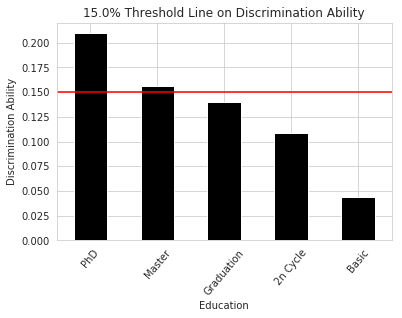

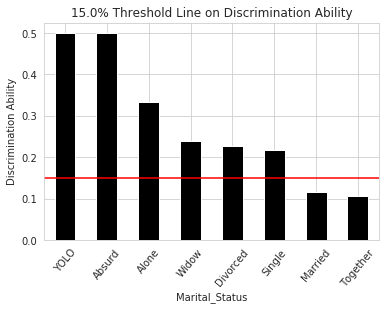

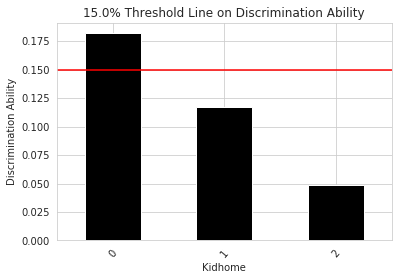

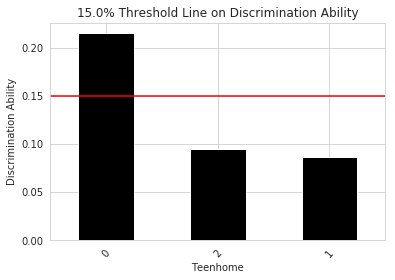

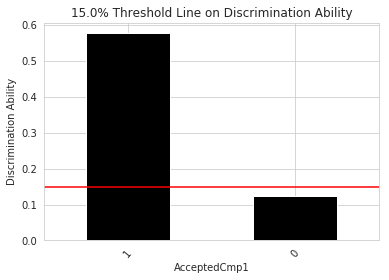

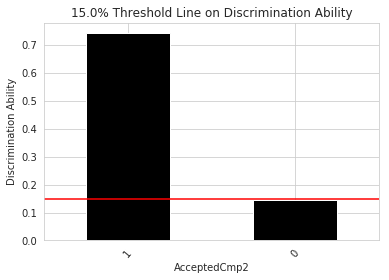

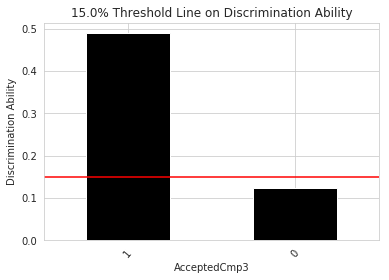

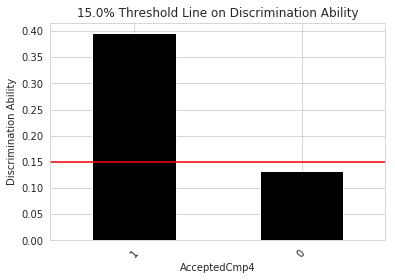

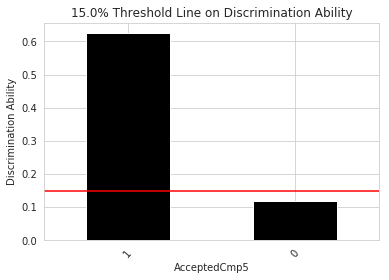

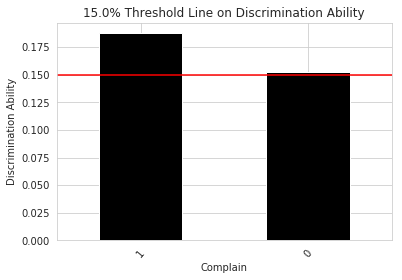

In [8]:
# Takes a dataframe, list of categorical features names (can be 1), the target variable name
# and the trheshold of discrimination ability and outputs all plots.
def cat_feat_plot(df, fc, target, thresh):

    sns.set_style("whitegrid")

    if (type(fc)==str):
        plot_df = cat_feat_describe(df, fc, target, 50, thresh).iloc[:,1]

        plot_df = plot_df.sort_values(ascending=False)

        ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
        ax.set_ylabel("Discrimination Ability", size = 10)
        ax.axhline(y=thresh, color="red")
        ax.set_xticklabels(plot_df.index, rotation=50, size=10)


        plt.show()
        
        
        
    else:
        for feat in fc:
            plot_df = cat_feat_describe(df, feat, target, 50, thresh).iloc[:,1]

            plot_df = plot_df.sort_values(ascending=False)

            
            ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
            ax.set_ylabel("Discrimination Ability", size = 10)
            ax.axhline(y=thresh, color="red")
            ax.set_xticklabels(plot_df.index, rotation=50, size=10)

            plt.show()
        
        
        
        
        
    
cat_feat_plot(train_data, feat_c, "Response", 0.15)

We can see that:

- $Education$: PhD and Master are above the 15% Discrimination Ability threshold.
- $Marital Status$: Only Married and Together are below the threshold.
- $KidHome$ & $TeenHome$: Only the clients with zero children or teen show a high discrimination ability.
- $Accepted Campaign$: All of the 5 previous campaigns show that, as expected, the clients which accepted the campaigns show discrimination ability above the threshold.
- $Complain$: While both who does and does not registered complains show high discrimination ability, only the ones who did complain show a discrimination ability higher than the threshold.

## CHANGE

In [9]:
data_ = train_data.copy()

low_discriminability_cat = ["Absurd", "Alone", "YOLO", "Married", "Together"]
data_['Marital_Status'].loc[data_['Marital_Status'].isin(low_discriminability_cat)] = 'Other'

/Users/RodolfoSaldanha/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
data_.groupby("Marital_Status").count().index

Index(['Divorced', 'Other', 'Single', 'Widow'], dtype='object', name='Marital_Status')

In [11]:
low_discriminability_cat = ["Graduation", "2n Cycle", "Basic"]
data_['Education'].loc[data_['Education'].isin(low_discriminability_cat)] = 'Other'

In [12]:
data_.groupby("Education").count().index

Index(['Master', 'Other', 'PhD'], dtype='object', name='Education')

In [13]:
data_['NumberOff'] = data_['Kidhome'] + data_['Teenhome']

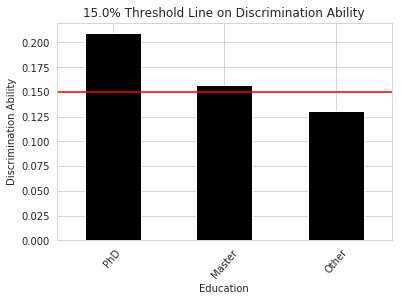

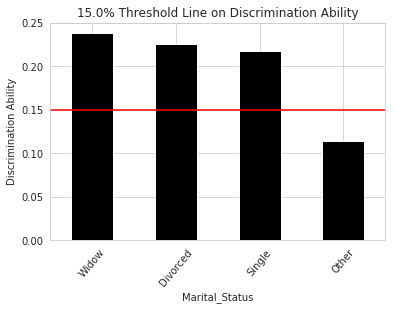

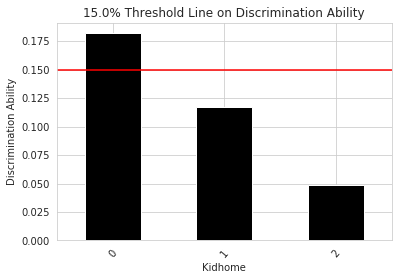

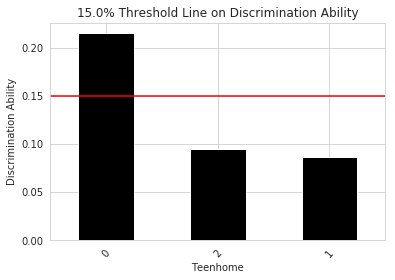

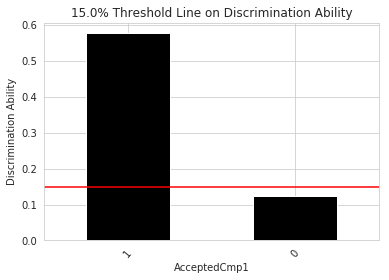

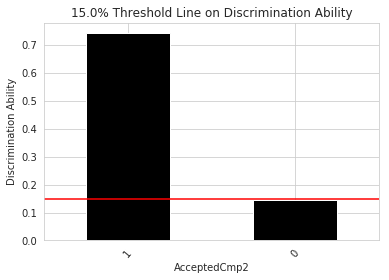

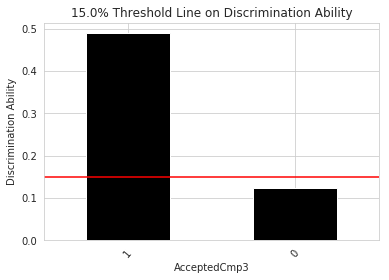

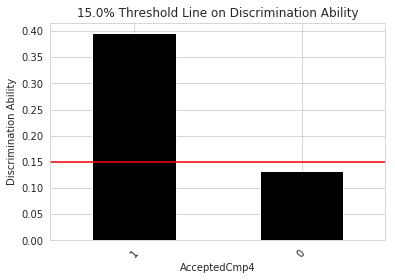

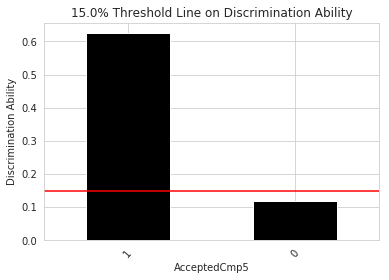

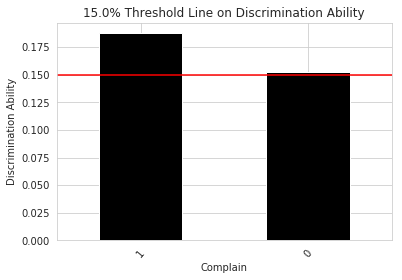

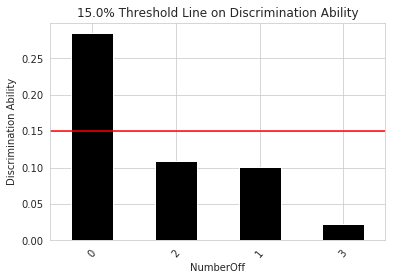

In [14]:
def cat_feat_plot(df, fc, target, thresh):

    sns.set_style("whitegrid")

    if (type(fc)==str):
        plot_df = cat_feat_describe(df, fc, target, 50, thresh).iloc[:,1]

        plot_df = plot_df.sort_values(ascending=False)

        ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
        ax.set_ylabel("Discrimination Ability", size = 10)
        ax.axhline(y=thresh, color="red")
        ax.set_xticklabels(plot_df.index, rotation=50, size=10)


        plt.show()
        
        
        
    else:
        for feat in fc:
            plot_df = cat_feat_describe(df, feat, target, 50, thresh).iloc[:,1]

            plot_df = plot_df.sort_values(ascending=False)

            
            ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
            ax.set_ylabel("Discrimination Ability", size = 10)
            ax.axhline(y=thresh, color="red")
            ax.set_xticklabels(plot_df.index, rotation=50, size=10)

            plt.show()
        
        
        
feat_c.append("NumberOff")
cat_feat_plot(data_, feat_c, "Response", 0.15)

In [15]:
low_discriminability_cat = ["1", "2"]
data_['Teenhome'].loc[data_['Teenhome'].isin(low_discriminability_cat)] = '1'

In [16]:
low_discriminability_cat = ["1", "2"]
data_['Kidhome'].loc[data_['Kidhome'].isin(low_discriminability_cat)] = '1'

In [17]:
low_discriminability_cat = ["1", "2", "3"]
data_['NumberOff'].loc[data_['NumberOff'].isin(low_discriminability_cat)] = '1'

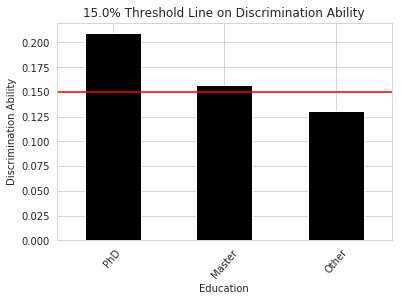

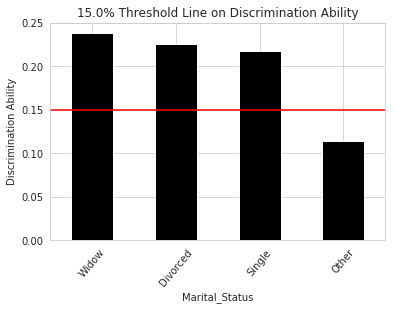

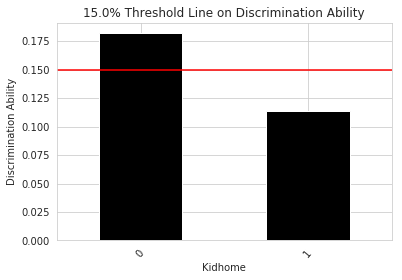

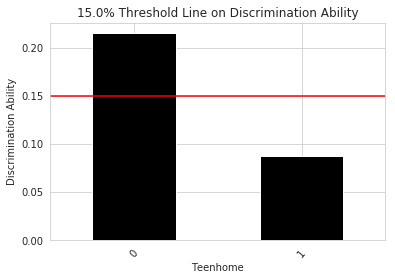

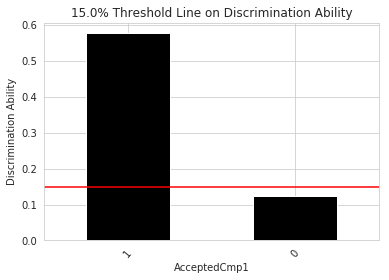

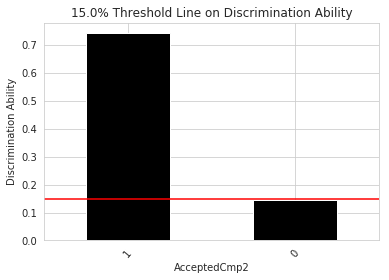

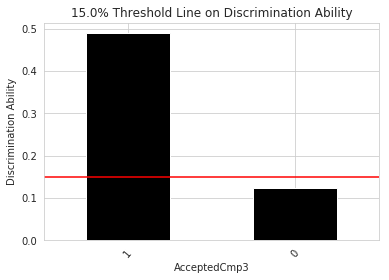

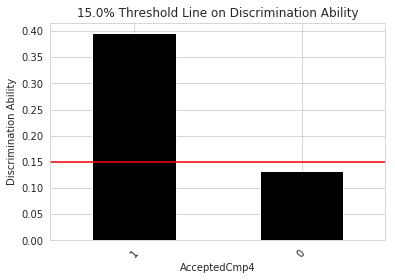

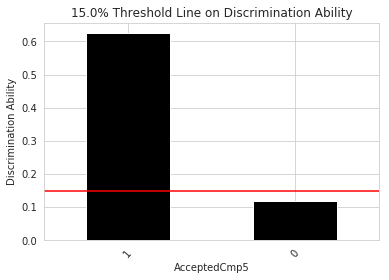

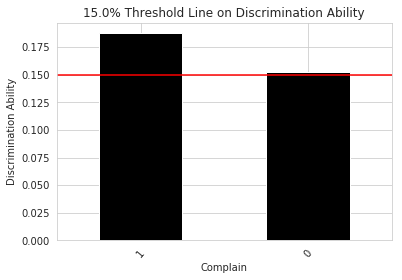

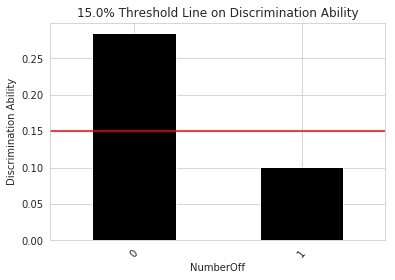

In [18]:
def cat_feat_plot(df, fc, target, thresh):

    sns.set_style("whitegrid")

    if (type(fc)==str):
        plot_df = cat_feat_describe(df, fc, target, 50, thresh).iloc[:,1]

        plot_df = plot_df.sort_values(ascending=False)

        ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
        ax.set_ylabel("Discrimination Ability", size = 10)
        ax.axhline(y=thresh, color="red")
        ax.set_xticklabels(plot_df.index, rotation=50, size=10)


        plt.show()
        
        
        
    else:
        for feat in fc:
            plot_df = cat_feat_describe(df, feat, target, 50, thresh).iloc[:,1]

            plot_df = plot_df.sort_values(ascending=False)

            
            ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
            ax.set_ylabel("Discrimination Ability", size = 10)
            ax.axhline(y=thresh, color="red")
            ax.set_xticklabels(plot_df.index, rotation=50, size=10)

            plt.show()
        

cat_feat_plot(data_, feat_c, "Response", 0.15)

## 1.3 Numerical Variables Analysis

### 1.3.1 Dealing with Dates - Dt_Customer into days since registration

In [19]:
# Gets a series of dates and its format as parameters and returns a series of days since that date until today.
def days_since(dates_series, date_format):

    n = len(dates_series)
    
    result = [0] * n

    for i in range(n):
        result[i] = (datetime.today()-datetime.strptime(dates_series[i], date_format)).days
    
    return result



data_["Days_Customer"] = days_since(list(data_.Dt_Customer), "%Y-%m-%d")

data_ = data_.drop(columns="Dt_Customer")

data_["Days_Customer"].head()

2128    2418
363     2337
1690    2099
1590    2324
1114    2057
Name: Days_Customer, dtype: int64

In [20]:
feat_n = list(data_.columns)

feat_n = list(filter(lambda x: x not in feat_c, feat_n))

feat_n.remove("ID") # Removing ID.
# List of Numerical Variables

data_[feat_n].describe() # Describing only Numerical Variables

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Response,Days_Customer
count,1792.000000,1776.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.0,1792.0,1792.000000,1792.000000
mean,1968.805804,52250.007883,48.877790,304.031250,26.133929,166.062500,37.355469,26.241071,44.166853,2.329799,4.055246,2.663504,5.781250,5.334263,3.0,11.0,0.152902,2108.641741
std,12.002662,26108.630435,29.021298,338.649209,40.019090,225.414983,55.218507,40.620246,52.360501,1.921417,2.737494,2.920317,3.254533,2.418842,0.0,0.0,0.359993,202.653343
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,1754.000000
25%,1959.000000,35616.750000,24.000000,23.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0,0.000000,1937.750000
50%,1970.000000,51231.000000,49.000000,172.000000,8.000000,66.000000,12.000000,8.000000,24.000000,2.000000,3.500000,2.000000,5.000000,6.000000,3.0,11.0,0.000000,2113.500000
75%,1977.000000,68118.000000,74.000000,508.250000,32.000000,226.250000,48.250000,31.000000,56.250000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0,0.000000,2282.250000
max,1996.000000,666666.000000,99.000000,1492.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0,1.000000,2453.000000


### 1.3.2 Variables with zero variance (constants)

In [21]:
std = data_[feat_n].describe().iloc[2,:]

const_lab = [std[std<0.05].index[0], std[std<0.05].index[1]]

std[std<0.05]

Z_CostContact    0.0
Z_Revenue        0.0
Name: std, dtype: float64

#### Removing constant variables

In [22]:
data_.drop(labels=const_lab, axis=1, inplace=True) # Now data_ does not contain zero variance variables.


feat_n = list(filter(lambda x: x not in const_lab, feat_n)) # Removing the names of the no varaiance variables
                                                        # from the list of numerical features.

In [23]:
data_.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,NumberOff,Days_Customer
2128,1631,1965,PhD,Other,65220.0,0,0,3,890,63,...,6,0,0,0,0,0,0,1,0,2418
363,933,1978,PhD,Other,37717.0,1,0,31,9,0,...,9,0,0,0,0,0,0,0,1,2337
1690,7397,1951,Other,Single,49090.0,0,1,45,494,5,...,7,0,0,0,0,0,0,0,1,2099
1590,4971,1962,PhD,Other,31497.0,0,1,22,108,1,...,8,0,0,0,0,0,0,0,1,2324
1114,11010,1984,PhD,Single,16269.0,1,0,75,19,3,...,8,0,0,0,0,0,0,0,1,2057


### 1.3.3 Inputing Missing Values
Instead of a simple mean inputation, we employ the Linear Regression model from sklearn package to perform a prediction of what the missing values in Income would be considering all the other variables and use it to input the missing values.

In [24]:
# Preparing all datasets to be used in the Linear Regression Model
X = data_
y = X["Income"]
y = y[-y.isna()]
X = X.drop(columns=["ID"])


X["Marital_Status"] = pd.Categorical(X["Marital_Status"])
X["Marital_Status"] = X["Marital_Status"].cat.codes

X["Education"] = pd.Categorical(X["Education"])
X["Education"] = X["Education"].cat.codes

x_pred = X[X.Income.isna()]
x_pred = x_pred.drop(columns="Income")

X = X[-X.Income.isna()]
X = X.drop(columns="Income")





# Linear Regression Model
reg = LinearRegression().fit(X, y)

# Predictions
y_pred = reg.predict(x_pred)

# Store the predictions in the missing values
data_.loc[data_.Income.isna(), "Income"] = y_pred

In [25]:
missing_rep(data_) # No more missings!

,Missings,Proportion of Missings,Higher than 3%


# CHANGE

The same was done to Year_birth since they were inconsistent.

In [26]:
data_[(2019 - data_["Year_Birth"])>=90]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,NumberOff,Days_Customer
339,1150,1899,PhD,Other,83532.0,0,0,36,755,144,...,1,0,0,1,0,0,0,0,0,2030
192,7829,1900,Other,Divorced,36640.0,1,0,99,15,6,...,5,0,0,0,0,0,1,0,1,2030
239,11004,1893,Other,Single,60182.0,0,1,23,8,0,...,4,0,0,0,0,0,0,0,1,1797


In [27]:
# Preparing all datasets to be used in the Linear Regression Model
X = data_
y = X[(2019 - X["Year_Birth"])<90].Year_Birth
X = X.drop(columns=["ID"])

X["Marital_Status"] = pd.Categorical(X["Marital_Status"])
X["Marital_Status"] = X["Marital_Status"].cat.codes

X["Education"] = pd.Categorical(X["Education"])
X["Education"] = X["Education"].cat.codes

x_pred = X[(2019 - X["Year_Birth"])>=90]
x_pred = x_pred.drop(columns="Year_Birth")

X = X[(2019 - X["Year_Birth"])<90]
X = X.drop(columns="Year_Birth")





# Linear Regression Model
reg = LinearRegression().fit(X, y)

# Predictions
y_pred = reg.predict(x_pred)

# Store the predictions in the missing values
data_.loc[(2019 - data_["Year_Birth"])>=90, "Year_Birth"] = y_pred.round()

### 1.3.4 Correlation Matrix between numerical variables


We employ the correlation matrix here in order to find variables that show high correlation between them so we could eliminate one or join them.

In [28]:
# The function to "zoom" in the correlation matrix.
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]



# Takes a dataframe and returns the correlation matrix while plotting the correlation matrix plot using hues of blue and red.
def corr_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()

    cmap = sns.diverging_palette(5, 250, as_cmap=True)


    vis = corr.style.background_gradient(cmap, axis=1)\
            .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
            .set_caption("Hover to magify")\
            .set_precision(2)\
            .set_table_styles(magnify())

    return vis



feat_n_ = feat_n.copy()
feat_n.remove("Response") # Removing the Targer variable from the list of numerical features to be analyzed by correlation.
corr_matrix(data_[feat_n])

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Days_Customer
Year_Birth,1,-0.17,-0.022,-0.18,-0.026,-0.042,-0.065,-0.039,-0.062,-0.071,-0.18,-0.14,-0.16,0.14,0.034
Income,-0.17,1,-0.0069,0.54,0.41,0.57,0.41,0.41,0.3,-0.069,0.35,0.58,0.5,-0.54,-0.0059
Recency,-0.022,-0.0069,1,0.0036,-0.018,0.013,3.4e-06,0.01,0.0022,0.018,-0.0064,0.018,-0.0062,-0.015,0.031
MntWines,-0.18,0.54,0.0036,1,0.38,0.56,0.39,0.38,0.39,0.017,0.55,0.64,0.65,-0.31,0.18
MntFruits,-0.026,0.41,-0.018,0.38,1,0.54,0.6,0.56,0.39,-0.14,0.29,0.49,0.45,-0.41,0.082
MntMeatProducts,-0.042,0.57,0.013,0.56,0.54,1,0.56,0.52,0.35,-0.14,0.29,0.71,0.48,-0.54,0.11
MntFishProducts,-0.065,0.41,3.4e-06,0.39,0.6,0.56,1,0.57,0.42,-0.14,0.29,0.53,0.45,-0.44,0.099
MntSweetProducts,-0.039,0.41,0.01,0.38,0.56,0.52,0.57,1,0.34,-0.13,0.32,0.5,0.44,-0.42,0.096
MntGoldProds,-0.062,0.3,0.0022,0.39,0.39,0.35,0.42,0.34,1,0.065,0.41,0.45,0.4,-0.25,0.17
NumDealsPurchases,-0.071,-0.069,0.018,0.017,-0.14,-0.14,-0.14,-0.13,0.065,1,0.24,-0.014,0.063,0.35,0.21


In [29]:
# Function to find the maximum value in a correlation matrix and print the line and column it is located.
def max_matrix(matrix):

    aux = 0
    line = ""
    col = ""
    for l in matrix:
        for i in matrix:
            if ((matrix[l][i]<1) & (abs(matrix[l][i])>abs(aux))):
                aux = matrix[l][i]
                line = l
                col = i


    print("Max Value:", aux,
          "\nLine:", line,
          "\nColumn:", col)


    return aux


max_matrix(data_[feat_n_].corr())

Max Value: 0.713659347998512 
Line: MntMeatProducts 
Column: NumCatalogPurchases


0.713659347998512

The highest correlation we have is between number of Meat PRoducst purchased and number of Catalog Purchases (0,72).

Should we do something about it?

### 1.3.5 Visualization of Numerical Variables

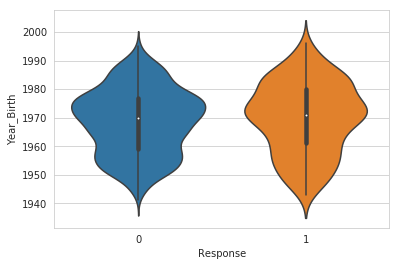

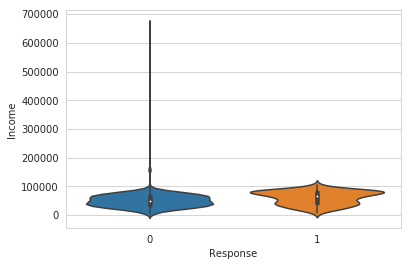

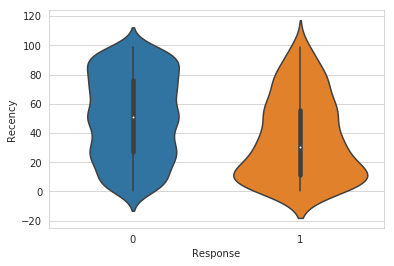

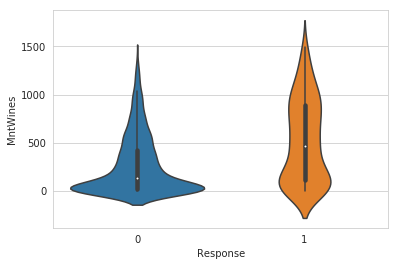

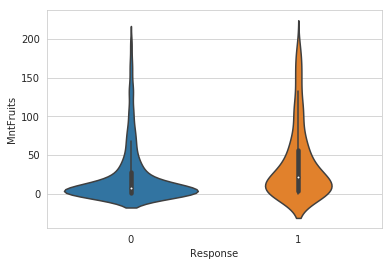

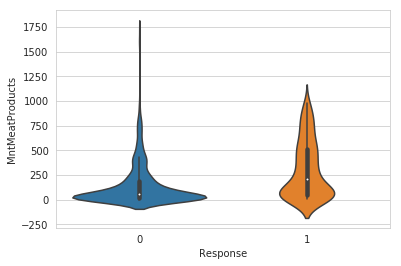

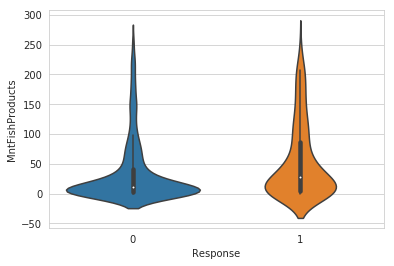

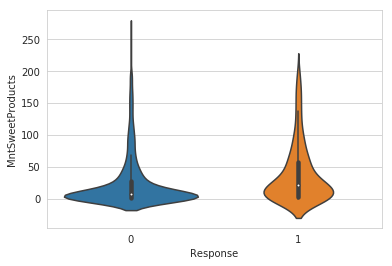

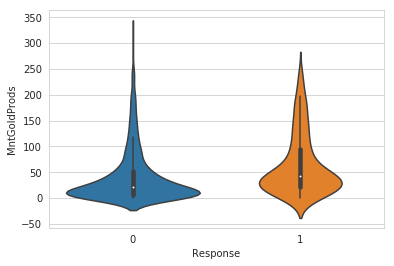

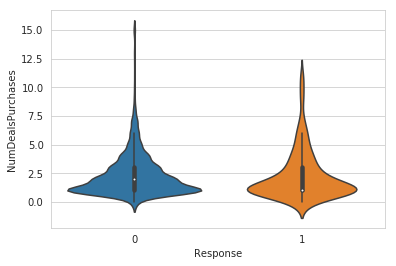

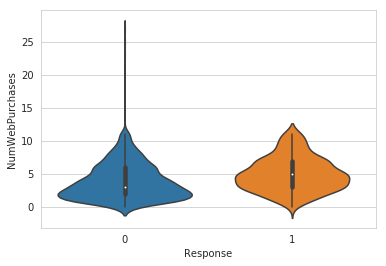

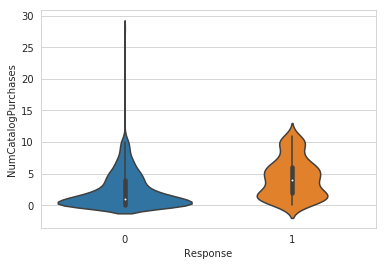

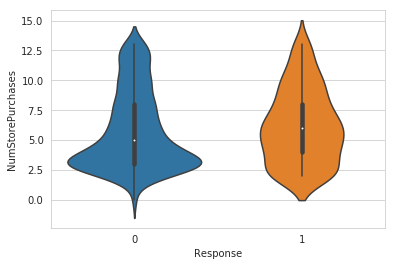

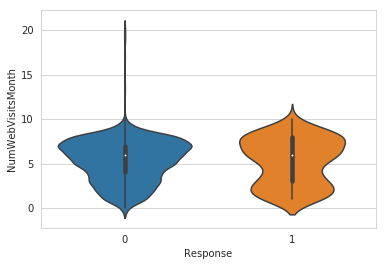

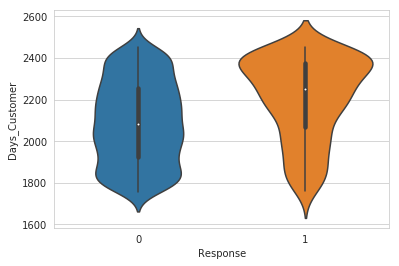

In [30]:
# Can give from 1 to all of numeric features a feat_n.
# Can give a categorical feature to be used (optional).
def num_feat_plot(df, feat_nlist, target, feat_clist = None):
    
    if(target in feat_nlist):
        feat_nl = feat_nlist.copy()
        feat_nl.remove(target)
    
    if (feat_clist==None):
        
        if (type(feat_nl)==str):
            
            sns.violinplot(data = df, y = feat_nl, x = target)
            plt.show()
            
            
        else:
            for feat in feat_nl:
                sns.violinplot(data = df, y = feat, x = target)
                plt.show()
        
    else:
        if (type(feat_nl)==str):
            
            sns.violinplot(data = data_, y = feat_nl, x = feat_clist, hue = target)
            plt.show()
            
            
        else:
            for feat in feat_nl:
                sns.violinplot(data = data_, y = feat, x = feat_clist, hue = target)
                plt.show()
                
    return

num_feat_plot(data_, feat_n_, "Response")

It is clear that Income holds many high outliers, while Year_Birth holds low outliers. Some of the number of purchases variables also show high outliers.

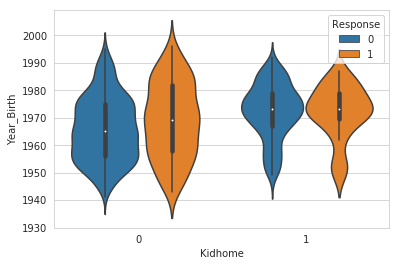

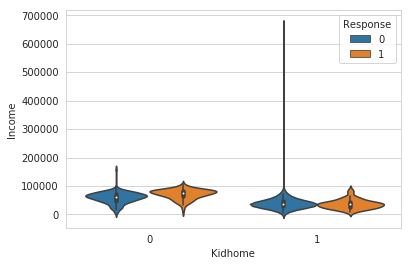

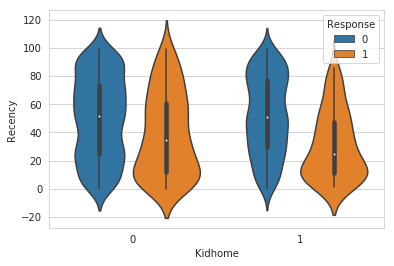

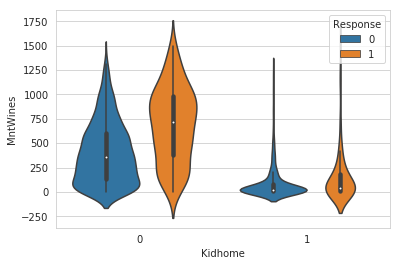

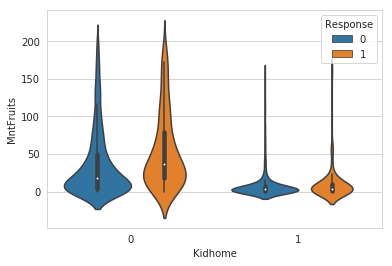

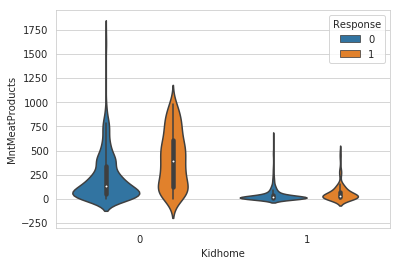

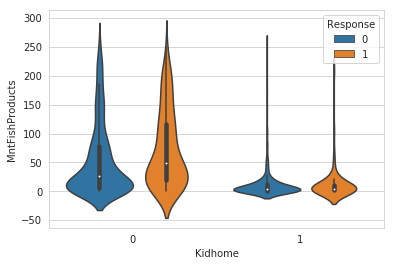

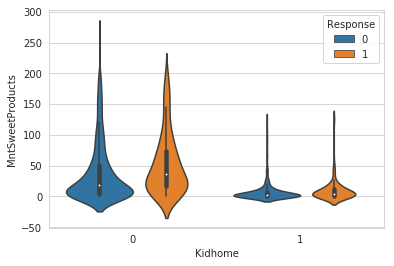

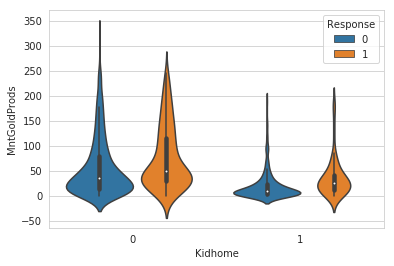

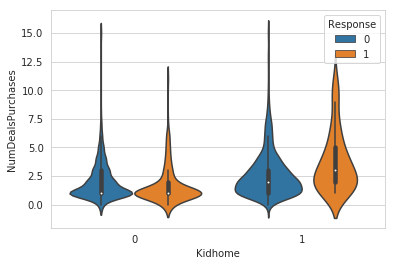

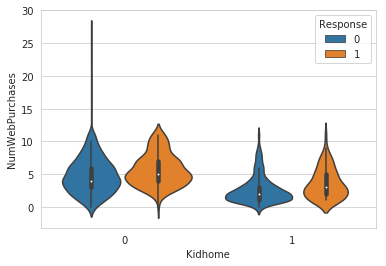

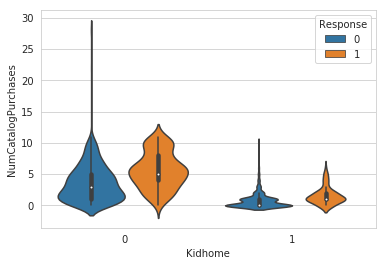

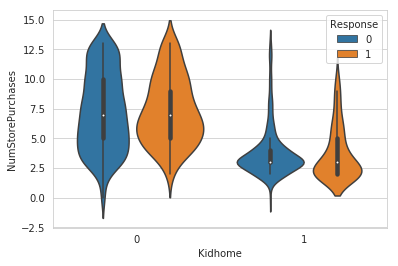

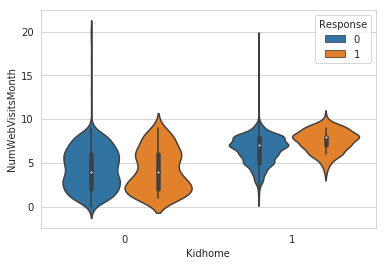

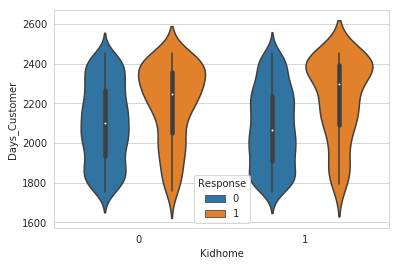

In [31]:
num_feat_plot(data_, feat_n_, "Response", "Kidhome")

## 1.4 Outlier Detection

### 1.4.1 Univariate Outliers

#### Standard Deviation Cutoffs

First we will use the Standard Deviation to find univariate outliers in numerical features. Every observation above 3 standard deviations of its own distribution will be considered an outlier.


In [32]:
# Function that is given a series and returns a list of same size indicating with boolean the outliers.
# 3 Standard Deviations is the default cutoff.
def filter_by_std(series_, n_stdev=3.0, return_thresholds=False):
    mean_, stdev_ = series_.mean(), series_.std()
    cutoff = stdev_ * n_stdev
    lower_bound, upper_bound = mean_ - cutoff, mean_ + cutoff
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]

    
# Function that is given a series and returns a list of same size indicating with boolean the outliers.
# 1.5 Interquartile Range is the default cutoff.
def filter_by_iqr(series_, k=1.5, return_thresholds=False):
    q25, q75 = np.percentile(series_, 25), np.percentile(series_, 75)
    iqr = q75-q25
    
    cutoff = iqr*k
    lower_bound, upper_bound = q25-cutoff, q75+cutoff
    
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]

In [33]:
outliers = pd.DataFrame()

for feat in feat_n:
    outliers = outliers.append(data_[filter_by_std(data_[feat], n_stdev=3)])
    

outliers

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,NumberOff,Days_Customer
687,1501,1982.0,PhD,Other,160803.0,0,0,21,55,16,...,0,0,0,0,0,0,0,0,0,2448
1300,5336,1971.0,Master,Other,157733.0,1,0,37,39,1,...,1,0,0,0,0,0,0,0,1,2144
2132,11181,1949.0,PhD,Other,156924.0,0,0,85,2,1,...,0,0,0,0,0,0,0,0,0,2058
617,1503,1976.0,PhD,Other,162397.0,1,1,31,85,1,...,1,0,0,0,0,0,0,0,1,2145
1653,4931,1977.0,Other,Other,157146.0,0,0,13,1,0,...,1,0,0,0,0,0,0,0,0,2180
164,8475,1973.0,PhD,Other,157243.0,0,1,98,20,2,...,0,0,0,0,0,0,0,0,1,1874
2233,9432,1977.0,Other,Other,666666.0,1,0,23,9,14,...,6,0,0,0,0,0,0,0,1,2146
655,5555,1975.0,Other,Divorced,153924.0,0,0,81,1,1,...,0,0,0,0,0,0,0,0,0,1896
824,5536,1959.0,Other,Other,87771.0,0,1,61,1492,38,...,6,0,1,1,1,1,0,1,1,2157
2098,1103,1976.0,Master,Other,81929.0,1,0,60,1486,55,...,6,1,0,1,0,0,0,1,1,2392


#### Anomaly Detection with Isolation Forest

Through the use of Isolation Forest algorithm, from scikitlearn, we can calculate the anomaly score of each point of the numerical features and, then, search for outliers.

Red areas indicate where the probability of observations existing there is low. The blue line, representing the anomaly score, tends to be similar to the distribution of the variable.

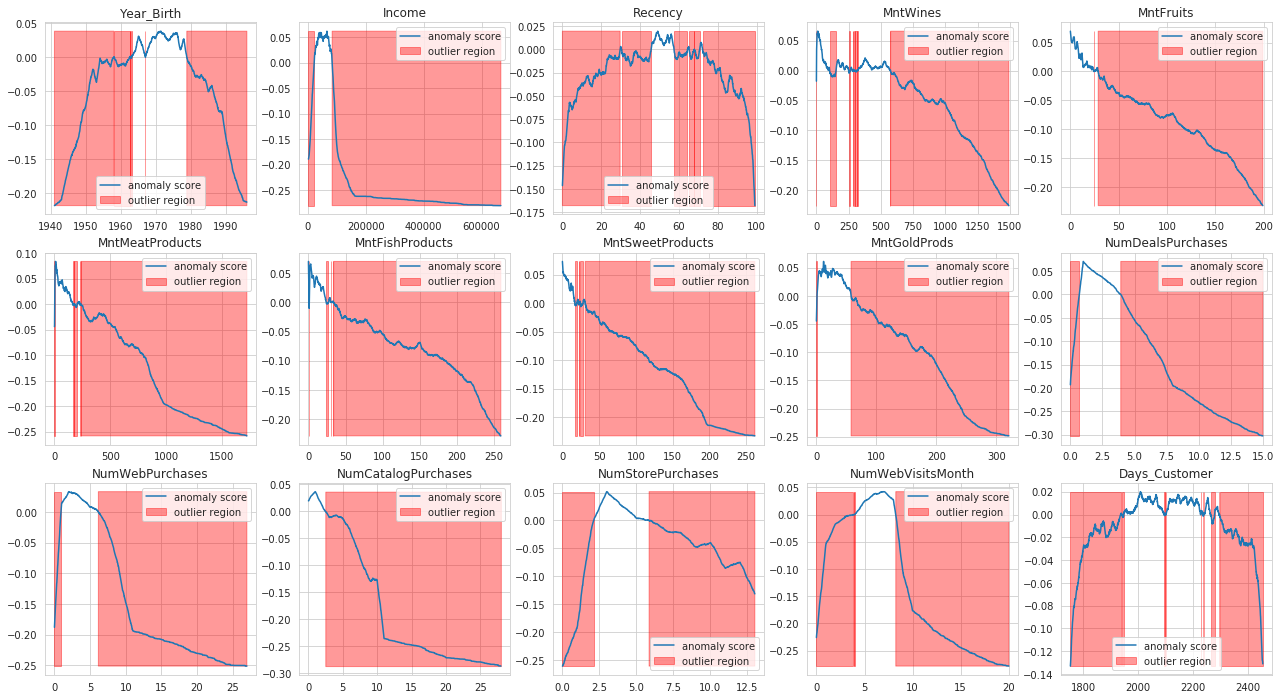

In [34]:
# Function that takes as parameters a dataframe, list of numerical features names, number of lines and columns of
# the resulting multiplot and plots the anomaly plots of all numerical features.
def anom_plot(df, num_feat_list, l, c):
    fig, axs = plt.subplots(l, c, figsize=(22, 12), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    for i, column in enumerate(num_feat_list):
        isolation_forest = IsolationForest(n_estimators=500, behaviour="new", contamination="auto")
        isolation_forest.fit(df[column].values.reshape(-1,1))

        xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
        anomaly_score = isolation_forest.decision_function(xx)
        outlier = isolation_forest.predict(xx)
    
        axs[i].plot(xx, anomaly_score, label='anomaly score')
        axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
        axs[i].legend()
        axs[i].set_title(column)
        
    return
    
    
    
anom_plot(data_, feat_n, 3, 5)

### 1.4.2 Multivariate Outliers
#### Mahalanobis Distance
The Euclidian distance is known to fail to find outliers when dealing with multi dimensional data. So we use the Mahalanobis Distance, because, since it uses the Eigenvalues of the variables instead of the original axis, it can make something similar to a feature scaling.

Basically it calculates the distance of each point to the center of mass measured in standard deviations through the inverted covariance matrix.

With these functions we can find the rows which represent multivariate outliers. The only path to take from this is removing these rows, as opposed to inputing the extreme values, like when we are dealing with univariate outliers.

In [35]:
# Simple function to check if the matrix is positive definite (for example, it will return False if the matrix contains NaN).
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False 

    
    
    
    
    
# The function to calculate the Mahalanobis Distance. Returns a list of distances.
def MahalanobisDist(data):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

        
        
        
        
# Function to detect multivariate outliers from the Mahalanobis Distances. Returns an array of indexes of the outliers.    
def MD_detectOutliers(data, extreme=False):
    MD = MahalanobisDist(data)

    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)


In [36]:
# Here we are creating an auxiliar dataframe and inputing NaN with the mean so we can calculate the Mahalanobis Distances.
data_aux = data_[feat_n_]

data_aux = data_aux.apply(lambda x: x.fillna(x.mean()), axis=0)

In [37]:
# Run the function
outliers_i = MD_detectOutliers(np.array(data_aux))
len(outliers_i)

37

These observations were detected as multivariate outliers by the Mahalanobis Distance method.

We could simply remove these rows from the dataset, since only 33 outlier observations were detected.

What should we do?

In [38]:
# Rows which were detected as multivariate outliers:
dat = pd.DataFrame()
for i in outliers_i:
    dat = dat.append(data_aux.iloc[i,:])
    
dat

,Days_Customer,Income,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Response,Year_Birth
2093,2311.0,79244.000000,212.0,102.0,245.0,125.0,61.0,471.0,10.0,1.0,7.0,4.0,1.0,58.0,1.0,1993.0
914,2327.0,95529.000000,250.0,29.0,24.0,890.0,27.0,770.0,3.0,1.0,7.0,7.0,3.0,29.0,1.0,1994.0
1042,2403.0,8028.000000,7.0,18.0,2.0,66.0,12.0,73.0,1.0,15.0,0.0,0.0,19.0,62.0,0.0,1991.0
252,2204.0,102692.000000,32.0,148.0,148.0,444.0,172.0,168.0,9.0,1.0,13.0,6.0,2.0,5.0,1.0,1974.0
644,2230.0,77632.000000,0.0,105.0,147.0,758.0,42.0,1200.0,2.0,1.0,6.0,4.0,2.0,73.0,1.0,1947.0
687,2448.0,160803.000000,17.0,16.0,4.0,1622.0,3.0,55.0,28.0,15.0,1.0,0.0,0.0,21.0,0.0,1982.0
1300,2144.0,157733.000000,2.0,1.0,8.0,9.0,0.0,39.0,0.0,0.0,1.0,1.0,1.0,37.0,0.0,1971.0
2132,2058.0,156924.000000,1.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,85.0,0.0,1949.0
67,1856.0,88194.000000,201.0,14.0,38.0,309.0,24.0,688.0,10.0,1.0,10.0,11.0,5.0,19.0,1.0,1979.0
2056,2385.0,71128.000000,20.0,159.0,31.0,447.0,0.0,958.0,10.0,3.0,12.0,2.0,7.0,80.0,0.0,1973.0


## 2. Means of Ranking Value of Features

We need means of raking the value of features so we can compare them and check which ones are the best in order to feed them as input to the pipeline. In order to do that we want an algorithm that can give us some measure of discrimination ability of all features in regards to our Response feature.

After we have one tool to measure the value, we can go ahead and create new features and compare them with the ones we already have.

### 2.1 The $\chi ^2$ Independence Test

The $\chi ^2$ test for independence, despite having the null hypothesis of independence of variables, can also measure the degree of association between two variables, which means we can use it to check which feature is similar to our Response variable.

In order to use as input of the test a numerical feature, the binning strategy with 10 bins was employed.

In [39]:
# Is given as input a dataframe, a list of continuous features names, a list of categorical features names,
# the name of the target feature and returns a dataframe with the discrimination ability of each feature and if
# its p-value is lower than 0.05.
# 10 is the default number of bins and uniform is the strategy used in the binning of continuous features.
def chisq_ranker(df, continuous_flist, categorical_flist, target, n_bins=10, binning_strategy="uniform"):
    chisq_dict = {}
    if  continuous_flist:
        bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', 
                               strategy=binning_strategy)
        for feature in continuous_flist:            
            feature_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
            feature_bin = pd.Series(feature_bin[:, 0], index=df.index)
            cont_tab = pd.crosstab(feature_bin, df[target], margins = False)
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2] 
    if  categorical_flist:
        for feature in categorical_flist:  
            cont_tab = pd.crosstab(df[feature], df[target], margins = False)          
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2]       
    
    df_chi = pd.DataFrame(chisq_dict, index=["Chi-Squared", "p-value"]).transpose()
    df_chi.sort_values("Chi-Squared", ascending=False, inplace=True)
    df_chi["valid"]=df_chi["p-value"]<=0.05
    
    
    return df_chi

We can now check the similarity of each feature with the Response, which, in turn, means we can check the discrimination ability of our features.

In the table we can see that, according to the test, the feature AcceptedCmp1 presents the higher discrimination ability, followed by the AcceptedCmp5 feature.

In [40]:
chisq_ranker(data_, feat_n, feat_c, "Response")

,Chi-Squared,p-value,valid
AcceptedCmp5,226.351048,3.725164e-51,True
AcceptedCmp1,160.519547,8.712337e-37,True
MntWines,156.414285,4.124840e-29,True
MntMeatProducts,127.776230,3.777005e-25,True
AcceptedCmp3,126.618364,2.251638e-29,True
NumCatalogPurchases,102.687702,1.433409e-20,True
NumberOff,93.635197,3.793809e-22,True
Days_Customer,91.653386,7.580318e-16,True
Income,85.918795,1.647875e-18,True
Recency,76.975820,6.428970e-13,True


### 2.2 Decision Tree Algorithm for Measuring Feature Worth
Even though the purpose of a DTA is not exactly measuring worth of features, we can use it that way. By employing the DecisionTreeClassifier from scikit-learn we can pull the features importances from the class.

In [41]:
# Function that receives a dataframe, list of feature names, name of target and DecisionTreeClassifier paramethers and
# returns a df with all features with a worth higher than zero and plots it.
def dta_feat_worth(df, feat_list, target, max_depth, min_samples_split, min_samples_leaf, seed):
    
    # Preparing the Input Data for the DTA
    X = data_.loc[:, feat_list].values
    y = data_[target].values
    
    
    # Run the estimation through DecisionTreeClassifier
    dtree = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=50, 
                                   min_samples_leaf = 20, random_state=seed)
    # Fits the DTClassifier with our data
    dtree = dtree.fit(X, y)
    
    
    # Create a dictionary with the name of all features and its importances according to the DTA estimation
    fi = dict(zip(columns, dtree.feature_importances_))
    # Then creates a Dataframe with it
    fidf = pd.DataFrame(fi, index=["worth"])
    # Transpose it because the way it is created it is on the other orientation
    fidf_t = fidf.transpose().sort_values(by="worth", ascending=False)
     # Removes features with worth 0 and puts it into a df called worth_df
    worth_df = fidf_t[fidf_t.worth>0]

    # Uses seaborn to create a plot with the worth of features
    plt.style.use('seaborn-whitegrid')
    axes = worth_df.sort_values(by="worth").plot.barh(y='worth', color='gray', legend=False)
    axes.set_title("Worth of features")
    # Repositions legend
    plt.legend(loc='lower right')
    plt.show()
    
    return worth_df

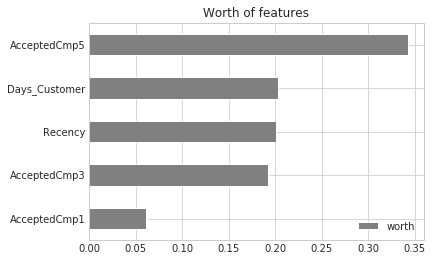

,worth
AcceptedCmp5,0.342441
Days_Customer,0.203522
Recency,0.200358
AcceptedCmp3,0.192335
AcceptedCmp1,0.061344


In [42]:
# Getting a feature list without categorical variables, ID and Response
columns = data_.columns
columns = columns.drop(["ID", "Response", "Marital_Status", "Education"])


dta_feat_worth(data_, columns, "Response", 5, 100, 10, seed)

## 3. Feature Engineering

Now, with a mean of comparing features according to their value, we can extract new features from the ones we already have in order to search for better features.

We will create all the new features and will compare and rank them afterwards, in the next section (4.)

### 3.1 Power Transformations

By applying the Box-Cox transformations on all features, we can try and find the ones that best fit each one in terms of discrimination ability.

But first, we need to perform feature scaling on continuous variables.

In [43]:
# Given a dataframe, numerical featue name list and a suffix for the name of the new variables returns a dataframe with the
# original and new variables.
def MinMaxScaling(df, num_feat_list, suffix):

    data_scaler = df[num_feat_list]

    fscaler = MinMaxScaler()
    scaled_d = fscaler.fit_transform(data_scaler.values)

    colnames = [s + suffix for s in data_scaler.columns]

    return pd.concat([df, pd.DataFrame(scaled_d, index=data_scaler.index, columns=colnames)], axis=1)


data_t = MinMaxScaling(data_, feat_n, "_t")
data_t.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,MntMeatProducts_t,MntFishProducts_t,MntSweetProducts_t,MntGoldProds_t,NumDealsPurchases_t,NumWebPurchases_t,NumCatalogPurchases_t,NumStorePurchases_t,NumWebVisitsMonth_t,Days_Customer_t
2128,1631,1965.0,PhD,Other,65220.0,0,0,3,890,63,...,0.169275,0.000000,0.095420,0.037383,0.266667,0.296296,0.142857,0.538462,0.30,0.949928
363,933,1978.0,PhD,Other,37717.0,1,0,31,9,0,...,0.003478,0.015444,0.003817,0.015576,0.066667,0.037037,0.000000,0.153846,0.45,0.834049
1690,7397,1951.0,Other,Single,49090.0,0,1,45,494,5,...,0.047536,0.027027,0.000000,0.311526,0.200000,0.259259,0.071429,0.692308,0.35,0.493562
1590,4971,1962.0,PhD,Other,31497.0,0,1,22,108,1,...,0.016232,0.050193,0.003817,0.012461,0.133333,0.111111,0.035714,0.307692,0.40,0.815451
1114,11010,1984.0,PhD,Single,16269.0,1,0,75,19,3,...,0.010435,0.011583,0.003817,0.000000,0.200000,0.111111,0.000000,0.230769,0.40,0.433476


In [44]:
# Receives a dataframe consisting only of scaled features and the target, and the name of the target feature.
# Returns both the dataframe with the features already transformed to the best transformation and a dictionary
# containing the name of each feature with its best transformation name.

def power_transf(df, target_feat):

    # define a set of transformations
    trans_dict = {"x": lambda x: x, "log": np.log, "sqrt": np.sqrt, 
                  "exp": np.exp, "**1/4": lambda x: np.power(x, 0.25), 
                  "**2": lambda x: np.power(x, 2), "**4": lambda x: np.power(x, 4)}

    target = target_feat
    best_power_dict = {}
    for feature in df.columns[:-1]:
        max_test_value, max_trans, best_power_trans = 0, "", None
        for trans_key, trans_value in trans_dict.items():
            # apply transformation
            feature_trans = trans_value(df[feature])
            if trans_key == "log":
                feature_trans.loc[np.isfinite(feature_trans)==False] = -50.

            # bin feature
            bindisc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy="uniform")
            feature_bin = bindisc.fit_transform(feature_trans.values[:, np.newaxis])
            feature_bin = pd.Series(feature_bin[:, 0], index=df.index)

            # obtain contingency table
            df_ = pd.DataFrame(data={feature: feature_bin, target: df[target]})
            cont_tab = pd.crosstab(df_[feature], df_[target], margins = False)        

            # compute Chi-Squared
            chi_test_value = stats.chi2_contingency(cont_tab)[0]
            if chi_test_value > max_test_value:
                max_test_value, max_trans, best_power_trans = chi_test_value, trans_key, feature_trans      

        best_power_dict[feature] = (max_test_value, max_trans, best_power_trans)
        df[feature] = best_power_trans
        
    return df, best_power_dict

In [45]:
# We need to create a dataframe containing only the scaled features with the Response.
df_pt = data_t.iloc[:,-15:]
df_pt["Response"] = data_["Response"]



data_pt, best_pt = power_transf(df_pt, "Response")

/Users/RodolfoSaldanha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/RodolfoSaldanha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/RodolfoSaldanha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/RodolfoSaldanha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/RodolfoSaldanha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/RodolfoSaldanha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/RodolfoSaldanha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/RodolfoSaldanha/anaconda3/lib/pyth

In [46]:
print("Best Power Transformation for each feature:")
for key in best_pt:
    print("\t->", key, best_pt[key][1])

Best Power Transformation for each feature:
	-> Year_Birth_t **4
	-> Income_t x
	-> Recency_t exp
	-> MntWines_t **2
	-> MntFruits_t x
	-> MntMeatProducts_t sqrt
	-> MntFishProducts_t sqrt
	-> MntSweetProducts_t sqrt
	-> MntGoldProds_t sqrt
	-> NumDealsPurchases_t sqrt
	-> NumWebPurchases_t sqrt
	-> NumCatalogPurchases_t sqrt
	-> NumStorePurchases_t sqrt
	-> NumWebVisitsMonth_t **1/4
	-> Days_Customer_t **4


In [47]:
# Replacing the old columns of scaled features with the features transformed according to the best transformation
coln = data_pt.columns[:-1]
data_t.drop(columns=coln, inplace=True)
data_t[coln] = data_pt[coln]

data_ = data_t
data_.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,MntMeatProducts_t,MntFishProducts_t,MntSweetProducts_t,MntGoldProds_t,NumDealsPurchases_t,NumWebPurchases_t,NumCatalogPurchases_t,NumStorePurchases_t,NumWebVisitsMonth_t,Days_Customer_t
2128,1631,1965.0,PhD,Other,65220.0,0,0,3,890,63,...,0.411431,0.000000,0.308901,0.193347,0.516398,0.544331,0.377964,0.733799,0.740083,0.814261
363,933,1978.0,PhD,Other,37717.0,1,0,31,9,0,...,0.058977,0.124274,0.061780,0.124805,0.258199,0.192450,0.000000,0.392232,0.819036,0.483911
1690,7397,1951.0,Other,Single,49090.0,0,1,45,494,5,...,0.218028,0.164399,0.000000,0.558146,0.447214,0.509175,0.267261,0.832050,0.769161,0.059343
1590,4971,1962.0,PhD,Other,31497.0,0,1,22,108,1,...,0.127404,0.224038,0.061780,0.111629,0.365148,0.333333,0.188982,0.554700,0.795271,0.442171
1114,11010,1984.0,PhD,Single,16269.0,1,0,75,19,3,...,0.102151,0.107624,0.061780,0.000000,0.447214,0.333333,0.000000,0.480384,0.795271,0.035307


### 3.2 Business Oriented Transformations

There are some transformations to our variables that can generate new features. Now we focus on the creation of business oriented features, like RFM, Monetary, Frequency, Proportion of Gold Products, etc.

They are built as follows:
#### 3.2.1 Numerical Transformations

In [48]:
# Percentage of Monetary Units spent on gold products out of the total spent
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = data_["MntGoldProds"].iloc[i]/sum(data_[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].iloc[i,:])
    
    
data_["PrpGoldProds"] = aux
data_["PrpGoldProds"].head()

2128    0.009449
363     0.250000
1690    0.170068
1590    0.026490
1114    0.000000
Name: PrpGoldProds, dtype: float64

In [49]:
# Number of Accepted Campaigns out of the last 5 Campaigns
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = sum(data_[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']].iloc[i,:])
    
    
data_["NmbAccCmps"] = aux
data_["NmbAccCmps"].head()

2128    0
363     0
1690    0
1590    0
1114    0
Name: NmbAccCmps, dtype: int64

In [50]:
# Proportion of Accepted Campaigns out of the last 5 Campaigns
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = sum(data_[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']].iloc[i,:])/5
    
    
data_["PrpAccCmps"] = aux
data_["PrpAccCmps"].head()

2128    0.0
363     0.0
1690    0.0
1590    0.0
1114    0.0
Name: PrpAccCmps, dtype: float64

In [51]:
# Proportion of Monetary Units spent on Wine out of the total spent
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = float(data_[["MntWines"]].iloc[i,:]/sum(data_[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].iloc[i,:]))
    
data_["PrpWines"] = aux
data_["PrpWines"].head()

2128    0.700787
363     0.450000
1690    0.840136
1590    0.715232
1114    0.431818
Name: PrpWines, dtype: float64

In [52]:
# Proportion of Monetary Units spent on Fruits out of the total spent
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = float(data_[["MntFruits"]].iloc[i,:]/sum(data_[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].iloc[i,:]))
    
data_["PrpFruits"] = aux
data_["PrpFruits"].head()

2128    0.049606
363     0.000000
1690    0.008503
1590    0.006623
1114    0.068182
Name: PrpFruits, dtype: float64

In [53]:
# Proportion of Monetary Units spent on Meat out of the total spent
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = float(data_[["MntMeatProducts"]].iloc[i,:]/sum(data_[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].iloc[i,:]))
    
data_["PrpMeat"] = aux
data_["PrpMeat"].head()

2128    0.229921
363     0.300000
1690    0.139456
1590    0.185430
1114    0.409091
Name: PrpMeat, dtype: float64

In [54]:
# Proportion of Monetary Units spent on Fish out of the total spent
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = float(data_[["MntFishProducts"]].iloc[i,:]/sum(data_[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].iloc[i,:]))
    
data_["PrpFish"] = aux
data_["PrpFish"].head()

2128    0.000000
363     0.200000
1690    0.011905
1590    0.086093
1114    0.068182
Name: PrpFish, dtype: float64

In [55]:
# Proportion of Monetary Units spent on Sweets out of the total spent
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = float(data_[["MntSweetProducts"]].iloc[i,:]/sum(data_[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].iloc[i,:]))
    
data_["PrpSweets"] = aux
data_["PrpSweets"].head()

2128    0.019685
363     0.050000
1690    0.000000
1590    0.006623
1114    0.022727
Name: PrpSweets, dtype: float64

In [56]:
# Monetary
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = sum(data_[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].iloc[i,:])
    
    
data_["Mnt"] = aux
data_["Mnt"].head()

2128    1270
363       20
1690     588
1590     151
1114      44
Name: Mnt, dtype: int64

In [57]:
# Buy Potential
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = float(sum(data_[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].iloc[i,:])/((data_[["Income"]].iloc[i,:])*2))
    
    
data_["BuyPot"] = aux
data_["BuyPot"].head()

2128    0.009736
363     0.000265
1690    0.005989
1590    0.002397
1114    0.001352
Name: BuyPot, dtype: float64

In [58]:
# Frequency
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    aux[i] = sum(data_[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].iloc[i,:])
    
    
data_["Freq"] = aux
data_["Freq"].head()

2128    23
363      4
1690    21
1590    10
1114     9
Name: Freq, dtype: int64

In [59]:
# Creating RFM feature using Recency, Freq and Mnt:
feature_list, n_bins = ["Recency", "Freq", "Mnt"], 5
rfb_dict = {}
for feature in feature_list:
    bindisc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy="quantile")
    feature_bin = bindisc.fit_transform(data_[feature].values[:, np.newaxis])
    feature_bin = pd.Series(feature_bin[:, 0], index=data_.index)
    feature_bin += 1
    
    if feature == "Recency":
        feature_bin = feature_bin.sub(5).abs() + 1
    rfb_dict[feature+"_bin"] = feature_bin.astype(int).astype(str)

data_["RFM"] = (rfb_dict['Recency_bin'] + rfb_dict['Freq_bin'] + rfb_dict['Mnt_bin']).astype(int)
data_.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,PrpAccCmps,PrpWines,PrpFruits,PrpMeat,PrpFish,PrpSweets,Mnt,BuyPot,Freq,RFM
2128,1631,1965.0,PhD,Other,65220.0,0,0,3,890,63,...,0.0,0.700787,0.049606,0.229921,0.000000,0.019685,1270,0.009736,23,555
363,933,1978.0,PhD,Other,37717.0,1,0,31,9,0,...,0.0,0.450000,0.000000,0.300000,0.200000,0.050000,20,0.000265,4,411
1690,7397,1951.0,Other,Single,49090.0,0,1,45,494,5,...,0.0,0.840136,0.008503,0.139456,0.011905,0.000000,588,0.005989,21,344
1590,4971,1962.0,PhD,Other,31497.0,0,1,22,108,1,...,0.0,0.715232,0.006623,0.185430,0.086093,0.006623,151,0.002397,10,422
1114,11010,1984.0,PhD,Single,16269.0,1,0,75,19,3,...,0.0,0.431818,0.068182,0.409091,0.068182,0.022727,44,0.001352,9,222


#### 3.2.2 Merging Categories
Now, regarding business oriented transformations we also need to merge categories without a high dicsimination ability in order to facilitate te ML algorithm we will employ.

By looking at the discrimination abilities of our features at point 1.2.2, we were able to define these strategies:
- Education: Phd, Master, others;
- Marital_Status: Single, Widow, Divorced, others;
- Kidhome & Teenhome: will be merged into a binary feature indicating presence of offspring.

In [60]:
# Merging Categories
# in Marital_Status:  "Single" as 3, "Widow" as 2, "Divorced" as 1 and ["Married", "Together"] as 0
data_["Marital_Status_bin"] = data_['Marital_Status'].apply(lambda x: 3 if x == "Single" else
                                                            (2 if x == "Widow" else
                                                             (1 if x == "Divorced" else 0))).astype(int)

# in Education: "Phd" as 2, "Master" as 1 and ['Graduation', 'Basic', '2n Cycle'] as 0
data_["Education_bin"] = data_['Education'].apply(lambda x: 2 if x == "PhD" else (1 if x == "Master" else 0)).astype(int)

In [61]:
data_["Kidhome"] = data_['Kidhome'].astype(int)
data_["Teenhome"] = data_['Teenhome'].astype(int)
data_["NumberOff"] = data_['NumberOff'].astype(int)

In [62]:
# HasOffsrping Feature
"""
aux = [0]* data_.shape[0]


for i in range(data_.shape[0]):
    if(int(data_[["Kidhome"]].iloc[i,:])+int(data_[["Teenhome"]].iloc[i,:])>0):
        aux[i] = 1
    else:
        aux[i] = 0
    
data_["HasOffspring"] = aux
data_["HasOffspring"].head()"""

'\naux = [0]* data_.shape[0]\n\n\nfor i in range(data_.shape[0]):\n    if(int(data_[["Kidhome"]].iloc[i,:])+int(data_[["Teenhome"]].iloc[i,:])>0):\n        aux[i] = 1\n    else:\n        aux[i] = 0\n    \ndata_["HasOffspring"] = aux\ndata_["HasOffspring"].head()'

In [63]:
# Adding these new categorical features to the list:
#feat_c.append("Marital_Status_bin")
#feat_c.append("Education_bin")
#feat_c.append("HasOffspring")

# Our data now:
data_.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,PrpFruits,PrpMeat,PrpFish,PrpSweets,Mnt,BuyPot,Freq,RFM,Marital_Status_bin,Education_bin
2128,1631,1965.0,PhD,Other,65220.0,0,0,3,890,63,...,0.049606,0.229921,0.000000,0.019685,1270,0.009736,23,555,0,2
363,933,1978.0,PhD,Other,37717.0,1,0,31,9,0,...,0.000000,0.300000,0.200000,0.050000,20,0.000265,4,411,0,2
1690,7397,1951.0,Other,Single,49090.0,0,1,45,494,5,...,0.008503,0.139456,0.011905,0.000000,588,0.005989,21,344,3,0
1590,4971,1962.0,PhD,Other,31497.0,0,1,22,108,1,...,0.006623,0.185430,0.086093,0.006623,151,0.002397,10,422,0,2
1114,11010,1984.0,PhD,Single,16269.0,1,0,75,19,3,...,0.068182,0.409091,0.068182,0.022727,44,0.001352,9,222,3,2


#### 3.2.3 Principal Component Analysis (PCA)
PCA is a useful tool for dimensionality reduction. We will try to use it as a transformation tool, as it could create useful new features consisting of the principal components grouping the other variables. It could lead to a good summarization of the data or an excessive loss of information.

First we will try an PCA with 2 components:

In [64]:
columns = data_.columns
columns = columns.drop(["ID", "Response", "Marital_Status", "Education"])


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_[columns])

data_["pc1_"] = principalComponents[:,0]
data_["pc2_"] = principalComponents[:,1]

Then a PCA with 5 components:

In [65]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(data_[columns])

data_["pc1"] = principalComponents[:,0]
data_["pc2"] = principalComponents[:,1]
data_["pc3"] = principalComponents[:,2]
data_["pc4"] = principalComponents[:,3]
data_["pc5"] = principalComponents[:,4]

data_.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,RFM,Marital_Status_bin,Education_bin,pc1_,pc2_,pc1,pc2,pc3,pc4,pc5
2128,1631,1965.0,PhD,Other,65220.0,0,0,3,890,63,...,555,0,2,12978.039042,-720.799202,12978.039042,-720.799202,262.422677,-173.357045,-214.289138
363,933,1978.0,PhD,Other,37717.0,1,0,31,9,0,...,411,0,2,-14546.646101,370.124058,-14546.646101,370.124058,257.174664,52.017340,-101.536771
1690,7397,1951.0,Other,Single,49090.0,0,1,45,494,5,...,344,3,0,-3163.300104,-143.769127,-3163.300104,-143.769127,10.456899,-187.882628,-3.889061


## 4. Evaluating Feature Selection
In order to assess if the feature selection performed is appropriate we will use K-Means clustering to measure accuracy.

First we will try to choose the best selection of features we have.

In [66]:
# New numerical feature list:
feat_n = data_.columns
feat_n = feat_n.drop(feat_c)
feat_n = feat_n.drop(["ID", "Response", "PrpGoldProds", "NmbAccCmps"])
feat_n = list(feat_n)

In [67]:
chisq_ranker(data_, feat_n, feat_c, "Response").head(15) # First 15 ranked features according to chisq_ranker

,Chi-Squared,p-value,valid
PrpAccCmps,385.732989,3.362392e-82,True
AcceptedCmp5,226.351048,3.725164e-51,True
Mnt,186.530965,2.188375e-35,True
AcceptedCmp1,160.519547,8.712337e-37,True
MntWines_t,159.658164,8.745949e-30,True
MntWines,156.414285,4.124840e-29,True
BuyPot,153.066736,2.041111e-28,True
MntMeatProducts_t,140.549669,1.823658e-26,True
pc2_,134.473138,4.300772e-28,True
pc2,134.473138,4.300772e-28,True


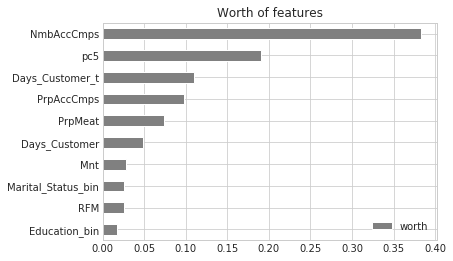

,worth
NmbAccCmps,0.383424
pc5,0.190839
Days_Customer_t,0.110072
PrpAccCmps,0.097503
PrpMeat,0.074312
Days_Customer,0.048480
Mnt,0.027744
Marital_Status_bin,0.025395
RFM,0.025216
Education_bin,0.017015


In [68]:
# Getting a feature list without categorical variables, ID and Response
columns = data_.columns
columns = columns.drop(["ID", "Response", "Marital_Status", "Education"])


dta_feat_worth(data_t, columns, "Response", 5, 100, 10, seed)

Looking at the tests above we can see some similarities but there is discrepancy in a sense that, in general, for the chisq_ranker the counting features are prioritized, while the dta_feat_worth test seems to give proportion features more value.


We will try to arrange a selection of features that incorporate the best mix of the results of both tests.

This attempt will be with this list of features:
- PrpAccCmps
- RFM
- Mnt
- PrpMeat
- Days_Customer_t
- MntWines_t
- PrpGoldProds
- Marital_Status_bin

$Note$: Even though pc5 seems like a good choice of feature, we will not use any of the new PCA features here because it will have a weird interaction when we use PCA to plot the K-Means result in two dimensions.

In [69]:
feature_list = ["PrpAccCmps", "RFM", "Mnt", "PrpMeat", "Days_Customer_t",
                     "MntWines_t", "PrpGoldProds", "Marital_Status_bin"]

features_df = data_t[feature_list]

Now we use a Standard Scaler to perform feature scaling on all selected features.

In [70]:
scaled_features = StandardScaler().fit_transform(features_df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=features_df.index, columns=features_df.columns)

Setting up the K-Means model with $K=2$ as the target feature, Response, shows only two states (0 or 1).

In [71]:
K = 2

kmeans = KMeans(n_clusters=K, max_iter=1000, random_state=12345, init = 'k-means++') # Set the number of clusters we want, the maximum number of iteration and a seed for the random state.
kmeans.fit(scaled_features_df)
labels = kmeans.labels_

We can now plot the results.

In a bidimensional space we can only compare two features a time.

Use x and y to select the variable according to its position in the feature_list:

In [72]:
feature_list

['PrpAccCmps',
 'RFM',
 'Mnt',
 'PrpMeat',
 'Days_Customer_t',
 'MntWines_t',
 'PrpGoldProds',
 'Marital_Status_bin']

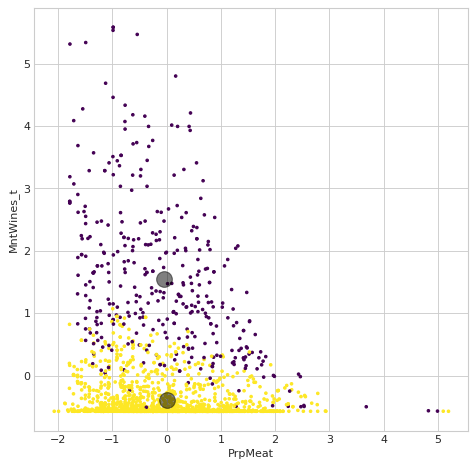

In [73]:
# Plotting the resulting clusters:

plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')


x = 3 # Select the variable that goes into the X axis in the graph.
y = 5 # Select the variable that goes into the Y axis in the graph.
plt.scatter(scaled_features_df.iloc[:, x], scaled_features_df.iloc[:, y], c=labels, s=5, cmap='viridis')




centers_cv = kmeans.cluster_centers_
plt.scatter(centers_cv[:, x], centers_cv[:, y], c='black', s=200, alpha=0.5);
plt.xlabel(scaled_features_df.columns[x], fontsize=10)
plt.ylabel(scaled_features_df.columns[y], fontsize=10)

plt.show()

In order to achieve a multidimensional behaviour evaluation of the K-Means model we will use Principal Component Analysis (PCA) to perform a dimension reduction from N to 2. PCA achieves this through an orthogonal transformation.

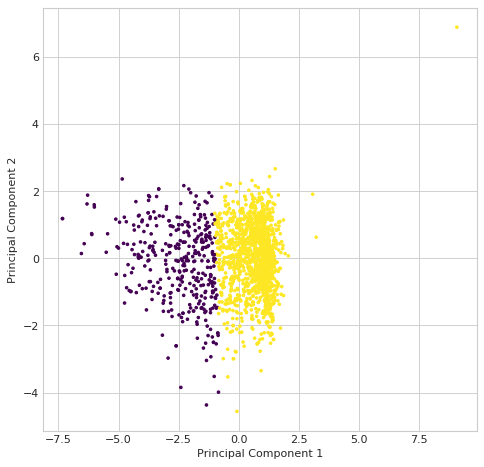

In [74]:
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_features_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])


plt.scatter(principalDf.iloc[:, 0], principalDf.iloc[:, 1], c=labels, s=5, cmap='viridis')
plt.xlabel(principalDf.columns[0], fontsize=10)
plt.ylabel(principalDf.columns[1], fontsize=10)
plt.show()

We can see the balance of points assigned to each cluster. More points were assigned to cluster 0 than to cluster 1.

In [75]:
Counter(labels)

Counter({0: 367, 1: 1425})

In [76]:
sum(data_t["Response"])

274

Although the model assigned 1419 to one cluster and 367 to another, only 265 out of the total clients did respond positively to the campaign.

367 is somewhat close to 265.

In order to measure it accuracy we count how many points the K-Means model assigned correctly and divide it by the lenght of our database:

In [77]:
sum(labels==data_t["Response"])/len(data_t["Response"])

0.19921875

79% of Accuracy is a decent measure. We could tinker a little more with the feature selection or go on to the pipeline.

## 5. Balancing Dataset

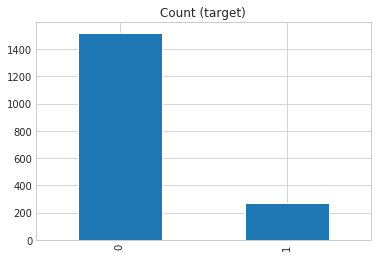

In [78]:
data_t['Response'].value_counts().plot(kind='bar', title='Count (target)');

In [79]:
drop = ['Response','Education', 'Marital_Status']
labels = data_t.columns[~data_t.columns.isin(drop)]

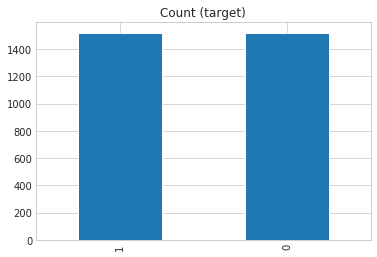

In [80]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(data_t[labels], data_t['Response'])

df = pd.DataFrame(X_sm, columns=labels)
df['Response'] = y_sm

df['Response'].value_counts().plot(kind='bar', title='Count (target)');

In [81]:
len(df)

3036

In [82]:
len(data_t)

1792

## 6. Export Pipeline
And when we are satisfied we can export our data as .xslx to be fed into our pipeline.

In [83]:
#data_t.to_excel("train_dataset_seed1.xlsx")

Models to test:
- Decision Tree
- Logistic Regression
- Random Forest
- SVM
- ANN

## Deep Learning

In [84]:
data_t.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,RFM,Marital_Status_bin,Education_bin,pc1_,pc2_,pc1,pc2,pc3,pc4,pc5
2128,1631,1965.0,PhD,Other,65220.0,0,0,3,890,63,...,555,0,2,12978.039042,-720.799202,12978.039042,-720.799202,262.422677,-173.357045,-214.289138
363,933,1978.0,PhD,Other,37717.0,1,0,31,9,0,...,411,0,2,-14546.646101,370.124058,-14546.646101,370.124058,257.174664,52.017340,-101.536771
1690,7397,1951.0,Other,Single,49090.0,0,1,45,494,5,...,344,3,0,-3163.300104,-143.769127,-3163.300104,-143.769127,10.456899,-187.882628,-3.889061
1590,4971,1962.0,PhD,Other,31497.0,0,1,22,108,1,...,422,0,2,-20763.095193,106.083709,-20763.095193,106.083709,220.796866,22.960011,-110.731902
1114,11010,1984.0,PhD,Single,16269.0,1,0,75,19,3,...,222,3,2,-35991.249621,18.365144,-35991.249621,18.365144,-55.526499,34.642871,99.968902


In [85]:
data_t.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'NumberOff', 'Days_Customer', 'Year_Birth_t',
       'Income_t', 'Recency_t', 'MntWines_t', 'MntFruits_t',
       'MntMeatProducts_t', 'MntFishProducts_t', 'MntSweetProducts_t',
       'MntGoldProds_t', 'NumDealsPurchases_t', 'NumWebPurchases_t',
       'NumCatalogPurchases_t', 'NumStorePurchases_t', 'NumWebVisitsMonth_t',
       'Days_Customer_t', 'PrpGoldProds', 'NmbAccCmps', 'PrpAccCmps',
       'PrpWines', 'PrpFruits', 'PrpMeat', 'PrpFish', 'PrpSweets', 'Mnt',
       'BuyPot', 'Freq', 'RFM', 'Marital_Status_bin', 'Education_bin', 'pc1_',


In [96]:
deep_dataset = df.drop(columns=['ID'])
#deep_dataset = df.drop(columns=['ID', 'Education', 'Marital_Status'])
deep_dataset.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Marital_Status_bin,Education_bin,pc1_,pc2_,pc1,pc2,pc3,pc4,pc5,Response
0,1965.0,65220.0,0.0,0.0,3.0,890.0,63.0,292.0,0.0,25.0,...,0.0,2.0,12978.039042,-720.799202,12978.039042,-720.799202,262.422677,-173.357045,-214.289138,1
1,1978.0,37717.0,1.0,0.0,31.0,9.0,0.0,6.0,4.0,1.0,...,0.0,2.0,-14546.646101,370.124058,-14546.646101,370.124058,257.174664,52.017340,-101.536771,0
2,1951.0,49090.0,0.0,1.0,45.0,494.0,5.0,82.0,7.0,0.0,...,3.0,0.0,-3163.300104,-143.769127,-3163.300104,-143.769127,10.456899,-187.882628,-3.889061,0
3,1962.0,31497.0,0.0,1.0,22.0,108.0,1.0,28.0,13.0,1.0,...,0.0,2.0,-20763.095193,106.083709,-20763.095193,106.083709,220.796866,22.960011,-110.731902,0
4,1984.0,16269.0,1.0,0.0,75.0,19.0,3.0,18.0,3.0,1.0,...,3.0,2.0,-35991.249621,18.365144,-35991.249621,18.365144,-55.526499,34.642871,99.968902,0


In [97]:
cat_columns = ['Marital_Status_bin','Education_bin']
deep_dataset = pd.get_dummies(deep_dataset, prefix_sep="_",
                              columns=cat_columns)

In [98]:
deep_dataset.shape

(3036, 1618)

In [99]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
df_scaled = scaler.fit_transform(deep_dataset)
df_scaled = pd.DataFrame(df_scaled, columns=[deep_dataset.columns])
df_scaled.head()

/Users/RodolfoSaldanha/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_bin_1.9495191350213452,Education_bin_1.9606218899587602,Education_bin_1.9606769212952697,Education_bin_1.9610161549030913,Education_bin_1.9701882100351196,Education_bin_1.972154322181224,Education_bin_1.9846521092121645,Education_bin_1.993830468276929,Education_bin_1.9983976409883915,Education_bin_2.0
0,0.436364,0.095483,0.0,0.0,0.030303,0.596515,0.316583,0.169275,0.000000,0.095420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.672727,0.054121,1.0,0.0,0.313131,0.006032,0.000000,0.003478,0.015444,0.003817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.181818,0.071225,0.0,1.0,0.454545,0.331099,0.025126,0.047536,0.027027,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.381818,0.044767,0.0,1.0,0.222222,0.072386,0.005025,0.016232,0.050193,0.003817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.781818,0.021865,1.0,0.0,0.757576,0.012735,0.015075,0.010435,0.011583,0.003817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [100]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_dim=66))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [101]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
history = model.fit(df_scaled, test_label, epochs=25)

ValueError: Error when checking input: expected dense_4_input to have shape (66,) but got array with shape (1618,)

In [103]:
test_label

620     0
582     0
175     0
1235    0
952     1
1174    0
0       1
561     0
1404    0
1048    1
1730    0
440     0
1569    0
530     0
573     0
1263    0
744     0
619     0
1782    0
1179    0
1398    0
232     0
1197    0
1982    0
1505    0
1201    0
844     0
1463    0
608     0
227     0
       ..
280     0
38      0
324     0
2066    0
2027    0
1819    0
1831    0
18      0
775     0
660     0
1610    0
168     0
1749    0
333     1
922     1
1072    0
1788    0
1336    0
1828    0
841     0
443     0
1873    0
150     0
1160    0
962     1
678     1
1370    0
1642    0
574     0
715     0
Name: Response, Length: 448, dtype: int64